# Introduction

# Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = '../data/popular_perfumes.csv'
df = pd.read_csv(data_path)

# Drop the 'Main Accords' column
df = df.drop('Main Accords', axis=1)

# Remove rows where 'Brand' is NaN
df = df.dropna(subset=['Brand'])

# Replace non-4-digit 'Release Year' values with NaN
df['Release Year'] = df['Release Year'].apply(lambda x: np.nan if pd.isnull(x) or len(str(x)) != 4 else x)

# Display the first few rows
df.head()

,Perfume Name,Brand,Release Year,Fragrance Notes,Rating,Image Path
0,Anubis (V.2) Aaron Terence Hughes 2020,Aaron Terence Hughes,2020,"Apple, Mandarin orange, Orange, Fruits, Ambrox...",7.4,../images_v2/Anubis_(V.2)_Aaron_Terence_Hughes...
1,Athena Aaron Terence Hughes 2023,Aaron Terence Hughes,2023,"Bergamot, Rose, Amber, Lily, Peony, Raspberry,...",8.2,../images_v2/Athena_Aaron_Terence_Hughes_2023.jpg
2,Adonis Aaron Terence Hughes 2021,Aaron Terence Hughes,2021,"Peppermint, Bergamot, Tonka bean, Vanilla, Amb...",8.3,../images_v2/Adonis_Aaron_Terence_Hughes_2021.jpg
3,ATH x FM - Smoulder Aaron Terence Hughes 2021,Aaron Terence Hughes,2021,"Neroli, Lemon, Tobacco, Frankincense, Sandalwo...",8.1,../images_v2/ATH_x_FM_-_Smoulder_Aaron_Terence...
4,Aura Aaron Terence Hughes 2023,Aaron Terence Hughes,2023,"Bergamot, Lily of the valley, Amber, Ambergris...",7.6,../images_v2/Aura_Aaron_Terence_Hughes_2023.jpg


# Data Exploration

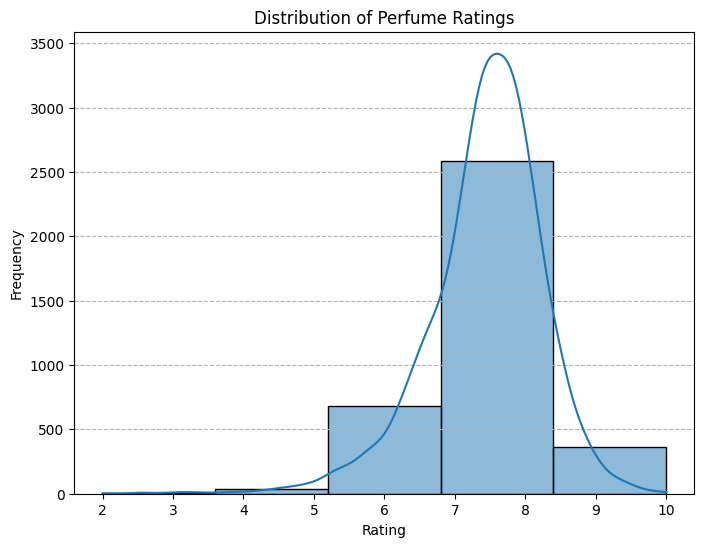

In [2]:
# Visualizing the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=5, kde=True)
plt.title('Distribution of Perfume Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# Sort the DataFrame by 'Release Year'
df = df.sort_values('Release Year')

# Now plot the distribution of release years
plt.figure(figsize=(8, 6))
sns.countplot(x='Release Year', data=df, palette="coolwarm")
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')

# Get the current x-ticks and labels
locs, labels = plt.xticks()

# Set the x-ticks to only the first and last year
plt.xticks([locs[0], locs[-1]], [labels[0].get_text(), labels[-1].get_text()])

plt.show()

/var/folders/s0/677hcg4s6qq1dq9p33lz22100000gn/T/ipykernel_23085/2601799282.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Release Year', data=df, palette="coolwarm")


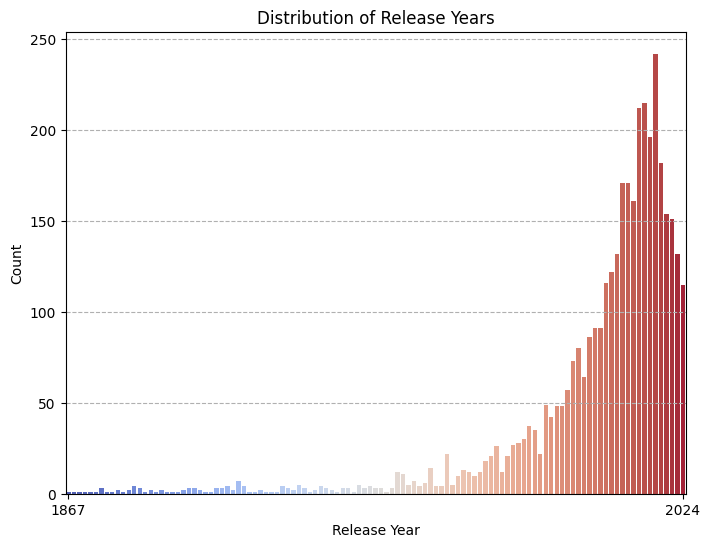

/var/folders/s0/677hcg4s6qq1dq9p33lz22100000gn/T/ipykernel_23085/2601799282.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Brand', data=df, palette="Set2")
/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12516 (\N{KATAKANA LETTER YA}) missing from current font.
  fig.canvas.print_figure(byt

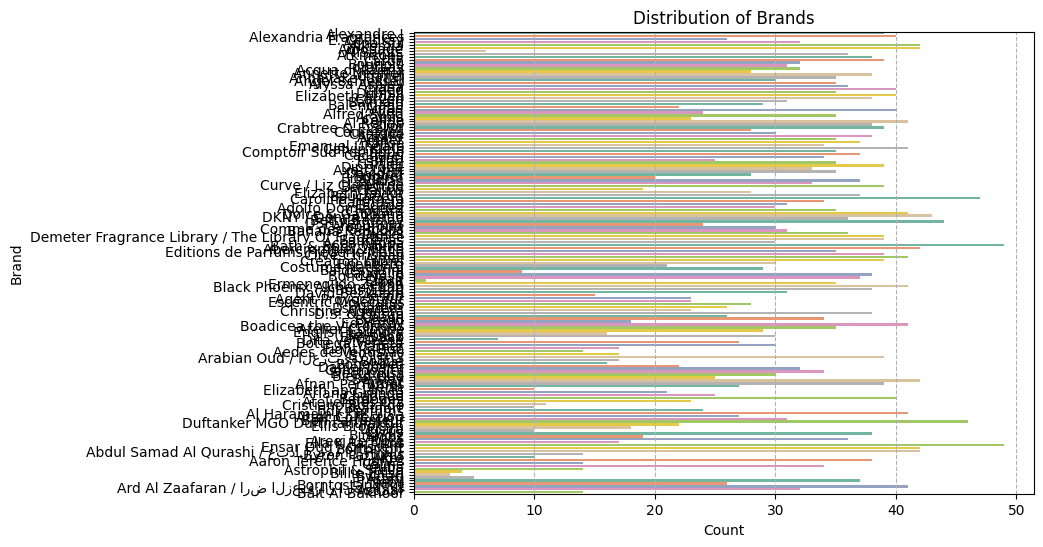

In [3]:
# Plotting the distribution of brands
plt.figure(figsize=(8, 6))
sns.countplot(y='Brand', data=df, palette="Set2")
plt.title('Distribution of Brands')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.grid(axis='x', linestyle='--')
plt.show()

# Implementation

Multi-class classification using pretained MobileNetV2

In [4]:
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split

# Count the number of instances for each class
class_counts = df['Brand'].value_counts()

# Get a list of classes that have more than one instance
valid_classes = class_counts[class_counts > 10].index

# Filter the DataFrame to only include these classes
df = df[df['Brand'].isin(valid_classes)]

# Now you can perform the stratified split
df_train, df_test_validation = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Brand'])
df_test, df_validation = train_test_split(df_test_validation, test_size=0.5, random_state=42, stratify=df_test_validation['Brand'])

def create_and_copy_images(df, destination_folder):
    # Create the directory if it does not exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    # Initialize a counter for skipped files
    skipped_files = 0

    for index, row in df.iterrows():
        source_path = row['Image Path']
        brand = row['Brand']
        
        # Skip entries where the image path is not a string
        if not isinstance(source_path, str):
            print(f"Skipping due to invalid path (not a string): {source_path}")
            skipped_files += 1
            continue
        
        # Create a directory for the brand if it doesn't exist
        brand_dir = os.path.join(destination_folder, brand)
        if not os.path.exists(brand_dir):
            os.makedirs(brand_dir)
        
        destination_path = os.path.join(brand_dir, os.path.basename(source_path))
        
        # Skip the file if it does not exist and increment the counter
        if not os.path.exists(source_path):
            print(f"Skipping missing file: {source_path}")
            skipped_files += 1
            continue
        
        shutil.copy(source_path, destination_path)
    
    # Print the number of skipped files
    if skipped_files > 0:
        print(f"Total skipped files: {skipped_files}")

# Paths for the train, test, and validation directories
train_images_dir = 'train_images'
test_images_dir = 'test_images'
validation_images_dir = 'validation_images'

# Create and copy images for train, test, and validation datasets
create_and_copy_images(df_train, train_images_dir)
create_and_copy_images(df_test, test_images_dir)
create_and_copy_images(df_validation, validation_images_dir)

Skipping missing file: ../images_v2/Purely_Orient_-_Cashmere_Wood_Ajmal.jpg
Total skipped files: 1


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import shutil

num_classes = 148

train_dir = '../model/train_images'
validation_dir = '../model/validation_images'
test_dir = '../model/test_images'

# Get all unique classes across all sets
all_classes = set(os.listdir(train_dir) + os.listdir(validation_dir) + os.listdir(test_dir))

# For each class, check if it appears in all sets
for class_ in all_classes:
    if not all(class_ in os.listdir(dir_) for dir_ in [train_dir, validation_dir, test_dir]):
        # If a class does not appear in all sets, remove it from the sets it appears in
        for dir_ in [train_dir, validation_dir, test_dir]:
            class_dir = os.path.join(dir_, class_)
            if os.path.exists(class_dir):
                shutil.rmtree(class_dir)  # This will remove the directory and all its contents

IMG_SIZE = 160  # Resize target
BATCH_SIZE = 32  # Batch size for training

# Data augmentation for the training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# No augmentation for validation and test data generators
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 4643 images belonging to 148 classes.
Found 1768 images belonging to 148 classes.
Found 1783 images belonging to 148 classes.


In [6]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
base_model.trainable = False

In [8]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # Updated loss function
              metrics=['accuracy'])

In [10]:
initial_epochs = 40

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=initial_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE)

Epoch 1/40


/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.0105 - loss: 5.4027 - val_accuracy: 0.0312 - val_loss: 4.7838
Epoch 2/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.0000e+00 - loss: 2.3415 - val_accuracy: 0.0000e+00 - val_loss: 2.3613
Epoch 3/40


2024-03-25 13:33:51.095651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)
2024-03-25 13:33:51.131383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.0417 - loss: 4.7835 - val_accuracy: 0.0875 - val_loss: 4.4126
Epoch 4/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - accuracy: 0.0938 - loss: 2.1824 - val_accuracy: 0.0000e+00 - val_loss: 2.3593
Epoch 5/40


2024-03-25 13:34:16.999824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:34:17.029797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.1030 - loss: 4.3637 - val_accuracy: 0.1699 - val_loss: 4.1201
Epoch 6/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.2188 - loss: 1.9897 - val_accuracy: 0.0000e+00 - val_loss: 2.1259
Epoch 7/40


2024-03-25 13:34:45.339748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:34:45.371877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.1650 - loss: 4.0802 - val_accuracy: 0.2261 - val_loss: 3.8654
Epoch 8/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.1875 - loss: 2.0119 - val_accuracy: 0.5000 - val_loss: 1.7377
Epoch 9/40


2024-03-25 13:35:14.812302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:35:14.848537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.2119 - loss: 3.8345 - val_accuracy: 0.2852 - val_loss: 3.6608
Epoch 10/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 0.2500 - loss: 1.7985 - val_accuracy: 0.3750 - val_loss: 1.7433
Epoch 11/40


2024-03-25 13:35:45.132823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:35:45.169116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.2742 - loss: 3.5767 - val_accuracy: 0.3216 - val_loss: 3.4774
Epoch 12/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - accuracy: 0.3750 - loss: 1.5511 - val_accuracy: 0.3750 - val_loss: 2.0026
Epoch 13/40


2024-03-25 13:36:15.160787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:36:15.201256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.3065 - loss: 3.4512 - val_accuracy: 0.3523 - val_loss: 3.3287
Epoch 14/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.2812 - loss: 1.7245 - val_accuracy: 0.3750 - val_loss: 1.5631
Epoch 15/40


2024-03-25 13:36:46.378471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:36:46.423391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.3418 - loss: 3.2356 - val_accuracy: 0.3727 - val_loss: 3.1929
Epoch 16/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.2812 - loss: 1.7269 - val_accuracy: 0.2500 - val_loss: 1.7802
Epoch 17/40


2024-03-25 13:37:18.303737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:37:18.348427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.3481 - loss: 3.1765 - val_accuracy: 0.3977 - val_loss: 3.0695
Epoch 18/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3750 - loss: 1.5526 - val_accuracy: 0.0000e+00 - val_loss: 1.8524
Epoch 19/40


2024-03-25 13:37:50.161920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:37:50.212174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.3986 - loss: 2.9889 - val_accuracy: 0.4119 - val_loss: 2.9626
Epoch 20/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.5312 - loss: 1.3066 - val_accuracy: 0.3750 - val_loss: 1.4797
Epoch 21/40


2024-03-25 13:38:23.522263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:38:23.566200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.3962 - loss: 2.9092 - val_accuracy: 0.4307 - val_loss: 2.8667
Epoch 22/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.4688 - loss: 1.3101 - val_accuracy: 0.5000 - val_loss: 1.4406
Epoch 23/40


2024-03-25 13:38:56.374768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:38:56.431950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - accuracy: 0.4295 - loss: 2.7684 - val_accuracy: 0.4466 - val_loss: 2.7812
Epoch 24/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.4375 - loss: 1.4760 - val_accuracy: 0.3750 - val_loss: 1.2317
Epoch 25/40


2024-03-25 13:39:28.880945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:39:28.929801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 231ms/step - accuracy: 0.4291 - loss: 2.7647 - val_accuracy: 0.4642 - val_loss: 2.7011
Epoch 26/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.3750 - loss: 1.3767 - val_accuracy: 0.3750 - val_loss: 1.3271
Epoch 27/40


2024-03-25 13:40:03.611603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:40:03.674506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.4525 - loss: 2.6612 - val_accuracy: 0.4773 - val_loss: 2.6292
Epoch 28/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.4375 - loss: 1.2609 - val_accuracy: 0.7500 - val_loss: 1.1185
Epoch 29/40


2024-03-25 13:40:36.905655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:40:36.966776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.4608 - loss: 2.6067 - val_accuracy: 0.4938 - val_loss: 2.5616
Epoch 30/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6250 - loss: 0.9337 - val_accuracy: 0.3750 - val_loss: 1.5196
Epoch 31/40


2024-03-25 13:41:11.527926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:41:11.589038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 227ms/step - accuracy: 0.4622 - loss: 2.5238 - val_accuracy: 0.5017 - val_loss: 2.5031
Epoch 32/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.4062 - loss: 1.3245 - val_accuracy: 0.3750 - val_loss: 1.3110
Epoch 33/40


2024-03-25 13:41:45.535117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:41:45.592566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.4936 - loss: 2.4217 - val_accuracy: 0.5125 - val_loss: 2.4499
Epoch 34/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.5938 - loss: 1.0079 - val_accuracy: 0.6250 - val_loss: 0.8648
Epoch 35/40


2024-03-25 13:42:18.970377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:42:19.027384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 226ms/step - accuracy: 0.4923 - loss: 2.4001 - val_accuracy: 0.5256 - val_loss: 2.3949
Epoch 36/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.5312 - loss: 1.2459 - val_accuracy: 0.6250 - val_loss: 1.0870
Epoch 37/40


2024-03-25 13:42:52.895514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:42:52.959514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - accuracy: 0.4922 - loss: 2.3904 - val_accuracy: 0.5392 - val_loss: 2.3410
Epoch 38/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.5312 - loss: 1.2516 - val_accuracy: 0.3750 - val_loss: 1.3488
Epoch 39/40


2024-03-25 13:43:27.560584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:43:27.627622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.5106 - loss: 2.3230 - val_accuracy: 0.5500 - val_loss: 2.2960
Epoch 40/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.4375 - loss: 1.2258 - val_accuracy: 0.6250 - val_loss: 0.8582


2024-03-25 13:44:01.753606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 13:44:01.811512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print('\nTest accuracy:', test_accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.5375 - loss: 2.3148

Test accuracy: 0.5329545736312866


## Fine-Tuning

In [12]:
# Unfreeze the Top Layers of the Model
# Make sure to recompile the model first if it was previously compiled.
base_model.trainable = True

# Define how many layers you want to freeze. In this case, we choose to fine-tune from layer 100 onwards.
fine_tune_at = 100

# Freeze all layers before `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [13]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])

In [14]:
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 40/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 288ms/step - accuracy: 0.1795 - loss: 3.9012 - val_accuracy: 0.5534 - val_loss: 2.1528
Epoch 41/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.3246 - loss: 3.1147 - val_accuracy: 0.3750 - val_loss: 1.1616
Epoch 42/55


2024-03-25 13:45:30.924658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.4053 - loss: 2.7616 - val_accuracy: 0.5585 - val_loss: 2.0366
Epoch 43/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 250ms/step - accuracy: 0.4463 - loss: 2.5729 - val_accuracy: 0.6250 - val_loss: 0.8657
Epoch 44/55


2024-03-25 13:46:50.982312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.4807 - loss: 2.4501 - val_accuracy: 0.5705 - val_loss: 1.9580
Epoch 45/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.4827 - loss: 2.3741 - val_accuracy: 0.7500 - val_loss: 0.8844
Epoch 46/55


2024-03-25 13:48:11.542804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.5153 - loss: 2.2375 - val_accuracy: 0.5858 - val_loss: 1.8736
Epoch 47/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.5230 - loss: 2.1612 - val_accuracy: 0.6250 - val_loss: 0.9418
Epoch 48/55


2024-03-25 13:49:33.436371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 46s 310ms/step - accuracy: 0.5401 - loss: 2.0761 - val_accuracy: 0.5977 - val_loss: 1.7917
Epoch 49/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.5519 - loss: 2.0144 - val_accuracy: 0.7500 - val_loss: 0.7884
Epoch 50/55


2024-03-25 13:50:55.748683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 292ms/step - accuracy: 0.5652 - loss: 1.9480 - val_accuracy: 0.6205 - val_loss: 1.7056
Epoch 51/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.5711 - loss: 1.9263 - val_accuracy: 0.5000 - val_loss: 1.0086
Epoch 52/55


2024-03-25 13:52:18.516511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 330ms/step - accuracy: 0.5791 - loss: 1.8755 - val_accuracy: 0.6358 - val_loss: 1.6283
Epoch 53/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.6000 - loss: 1.8386 - val_accuracy: 0.6250 - val_loss: 0.8100
Epoch 54/55


2024-03-25 13:53:47.012603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 48s 319ms/step - accuracy: 0.5993 - loss: 1.7790 - val_accuracy: 0.6534 - val_loss: 1.5527
Epoch 55/55
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.6048 - loss: 1.7557 - val_accuracy: 0.6250 - val_loss: 0.7984


2024-03-25 13:55:13.294258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Evaluation and Prediction

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print('\nTest accuracy:', test_accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.6591 - loss: 1.5410

Test accuracy: 0.6499999761581421


In [16]:
# Assuming 'train_generator' is your training data generator
class_indices = train_generator.class_indices

# Sort the class indices by their numeric value to ensure correct order
class_names = sorted(class_indices, key=class_indices.get)

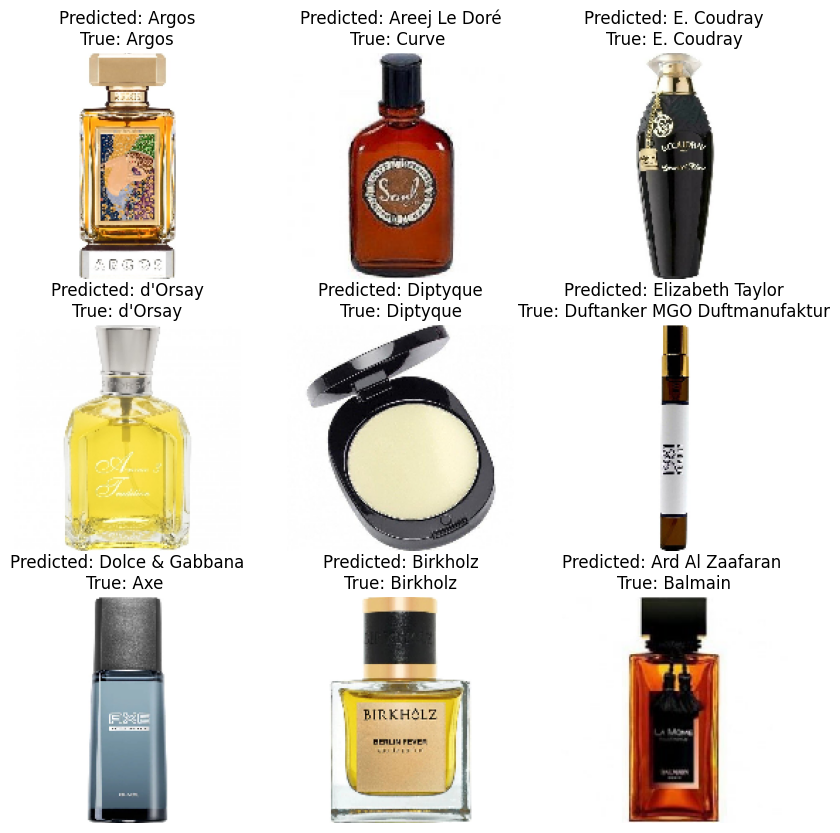

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve a batch of images from the test set
image_batch, label_batch = next(test_generator)

# Assuming your model's predictions
predictions = model.predict_on_batch(image_batch)

# Convert predictions and labels to class indices
predicted_class_indices = np.argmax(predictions, axis=-1)
true_class_indices = np.argmax(label_batch, axis=-1)

# Ensure the images are scaled correctly for display
image_batch_display = image_batch * 255.0
image_batch_display = image_batch_display.astype('uint8')  # Ensure correct data type for display

plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images and predictions
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch_display[i])  # Use the adjusted image batch here
    predicted_label = class_names[predicted_class_indices[i]]
    true_label = class_names[true_class_indices[i]]
    plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}')
    plt.axis('off')
plt.show()